<a href="https://colab.research.google.com/github/as2c/MLP---Cosmology/blob/main/Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code, our objective is to train some classic models such as SVM, KNN, RandomForest, etc on our test data, and try to evaluate their efficiency by plotting confusion matrixes, learning curves, validation curves, and measuring the prediction time. 

# Import phase I data

Import required libreries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import timeit
%alias_magic t timeit
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
data = pd.read_csv(r'/content/drive/MyDrive/density_contrast.csv')
data.head()

,particle_id,in-halo,den_contrast for 12.4,den_contrast for 13.0,den_contrast for 13.6
0,6872359,0,-0.047697,-0.043106,-0.038331
1,5818539,0,-0.034318,-0.036062,-0.034318
2,9365399,1,-0.036311,-0.041542,-0.037702
3,7002365,1,-0.022502,-0.032049,-0.035913
4,9348414,0,-0.050822,-0.046012,-0.039032


In [20]:
data = data.sort_values( by =['den_contrast for 12.4'])
X, Y = data.iloc[:,2:], data['in-halo']
tst_size = 0.2
ns, nf = np.shape(X) 
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )

In [21]:
print('X_train :',len(X_train),'   X_test :',len(X_test))

X_train : 8000    X_test : 2000


In [22]:
X_test,X_train = np.array(X_test),np.array(X_train)
Y_test,Y_train = np.array(Y_test),np.array(Y_train)
X ,Y= np.array(X),np.array(Y)

# Random Forrest

In [23]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)
#check 
%t classifier.fit(X_train , Y_train)

#Testing the classification on the test sample
Y_predict = classifier.predict(X_test)
#check
%t Y_predict = classifier.predict(X_test)
print(len(Y_test))
print(len(Y_predict[Y_predict== 1]))

1 loop, best of 5: 290 ms per loop
10 loops, best of 5: 20.9 ms per loop
2000
403


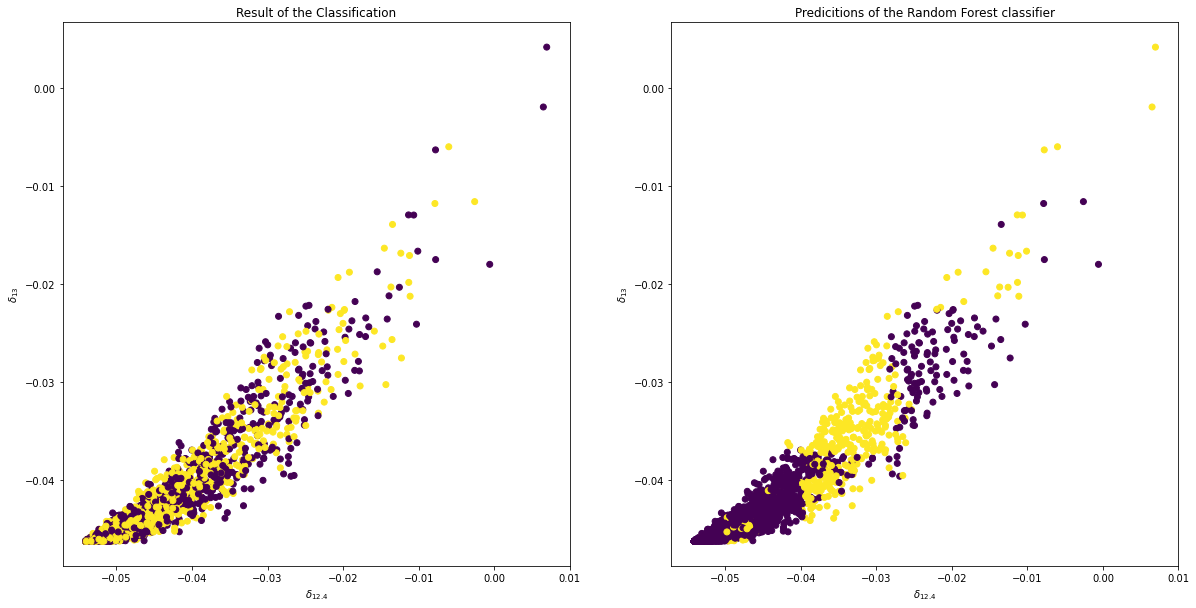

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121 , xlabel = '$\delta_{12.4}$', ylabel='$\delta_{13}$' , title = 'Result of the Classification')

ax.scatter(*X_test[:,:2].T, c=Y_test)    

ax = fig.add_subplot(122 , xlabel = '$\delta_{12.4}$ ', ylabel='$\delta_{13}$', title = 'Predicitions of the Random Forest classifier')
plt.scatter(*X_test[:,:2].T, c = Y_predict)
plt.show()


## The Classification Report 

In [25]:
from sklearn.metrics import classification_report
clf_report = classification_report(Y_test, Y_predict)
print(clf_report)

              precision    recall  f1-score   support

           0       0.49      0.79      0.61       990
           1       0.49      0.20      0.28      1010

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.44      2000
weighted avg       0.49      0.49      0.44      2000



## Fine Tunning The Hyperparameter

In [26]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 110, num = 12)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [28]:
# Random search of parameters, using 2 fold cross validation, 
# search across 5 different combinations, and use all available cores
print('start')
rf_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 5, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

print(rf_random.best_params_)

start
Fitting 2 folds for each of 5 candidates, totalling 10 fits
{'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


## Learning Curve

In [29]:
#first we should do the classification with the optimal values.

classifier = RandomForestClassifier(n_estimators = 1400, min_samples_split = 5, min_samples_leaf = 1, 
                                    max_features = 'sqrt', max_depth = 20, bootstrap = True, random_state=0)

train_sizes = np.arange(1000,8000,500)

#computing training score and validation score for each sample size cv times
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator= classifier , X = X,
                                                   y = Y, train_sizes = train_sizes, cv = 5, random_state = 0)

print('Training scores:\n\n', pd.DataFrame( train_scores) )

print('\nValidation scores:\n\n', pd.DataFrame(validation_scores) )

Training scores:

            0         1         2         3         4
0   0.919000  0.580000  0.580000  0.580000  0.580000
1   0.927333  0.639333  0.639333  0.639333  0.639333
2   0.934500  0.692000  0.692500  0.692500  0.692500
3   0.937200  0.748400  0.732400  0.732400  0.732400
4   0.944333  0.787000  0.765000  0.765000  0.765000
5   0.945143  0.812286  0.790857  0.790857  0.790857
6   0.944000  0.832500  0.810000  0.810750  0.810750
7   0.947111  0.846000  0.826444  0.824889  0.824889
8   0.950800  0.859200  0.842400  0.841000  0.841000
9   0.950909  0.869818  0.854000  0.850000  0.850000
10  0.952833  0.878667  0.863833  0.852833  0.857000
11  0.952154  0.884615  0.870923  0.862308  0.864154
12  0.952286  0.892286  0.878000  0.869857  0.874714
13  0.956933  0.897600  0.885733  0.877200  0.877600

Validation scores:

          0       1       2       3       4
0   0.5015  0.5010  0.5035  0.5005  0.5000
1   0.5015  0.5020  0.4995  0.5000  0.5000
2   0.5015  0.5000  0.5005  0.5130 

[0.6478     0.69693333 0.7408     0.77656    0.80526667 0.826
 0.8416     0.85386667 0.86688    0.87494545 0.88103333 0.88683077
 0.89342857 0.89901333]
[0.5013 0.5006 0.5024 0.4999 0.5019 0.4991 0.5004 0.5042 0.5038 0.5029
 0.5024 0.5076 0.5045 0.5029]


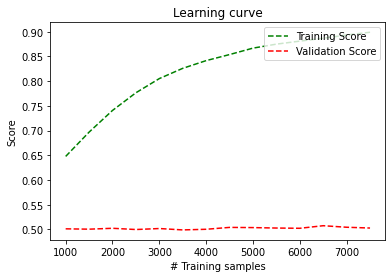

In [ ]:
train_scores_mean = train_scores.mean(axis = 1)
print(train_scores_mean)
validation_scores_mean = validation_scores.mean(axis = 1)
print(validation_scores_mean)

plt.title('Learning curve')
plt.plot(ns_list, train_scores_mean,'g--',label = 'Training Score')
plt.plot(ns_list, validation_scores_mean, 'r--', label = 'Validation Score')
plt.xlabel('# Training samples')
plt.ylabel('Score')
plt.legend(loc='upper right')

plt.show()

## Training with optimized hyperparameter

In [ ]:
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y , train_size = 1000 , random_state= 0)
X_test = np.array(X_test)
X_train = np.array(X_train)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)
X = np.array(X)
Y = np.array(Y)

In [31]:
classifier = RandomForestClassifier(n_estimators = 1400, min_samples_split = 5, min_samples_leaf = 1, 
                                    max_features = 'sqrt', max_depth = 20, bootstrap = True, random_state=0)
start_train = time.time()
%t classifier.fit(X_train , Y_train)
runtime_train = time.time() - start_train

#Testing the classification on the test sample
# Y_predict = classifier.predict(X_test)
start_pred = time.time()
%t Y_predict = classifier.predict(X_test)
runtime_pred = time.time() - start_pred

print(len(Y_test))
print(len(Y_predict[Y_predict == 1]))

1 loop, best of 5: 13.1 s per loop
1 loop, best of 5: 656 ms per loop
2000
403


In [ ]:
#Evaluating the new trained model:
final_report = classification_report(Y_test, Y_predict)
print(final_report)

              precision    recall  f1-score   support

           0       0.50      0.42      0.46      4529
           1       0.50      0.59      0.54      4471

    accuracy                           0.50      9000
   macro avg       0.50      0.50      0.50      9000
weighted avg       0.50      0.50      0.50      9000



##Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test , Y_predict)
print('Here is the confusion matrix for the LG classifier: \n'  )
print('TP = {}'.format(conf_matrix[0][0]),'  FP = {}'.format(conf_matrix[0][1]) , '\n')
print('FN = {}'.format(conf_matrix[1][0]),'  TN = {}'.format(conf_matrix[1][1]) , '\n')

Here is the confusion matrix for the LG classifier: 

TP = 1888   FP = 2641 

FN = 1854   TN = 2617 



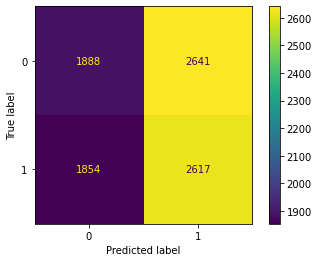

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix( classifier, X_test, Y_test)  
plt.show()

##Accuracy

$Accuracy = \frac{TP + TN}{TP+TN+FP+FN} * 100$

In [ ]:
acurracy = (conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
print('The accuracy of the model is {}%' .format(round(acurracy*100, 3)))

The accuracy of the model is 50.056%


## Precision - Recall curve

[[0.63435321 0.36564679]
 [0.30929299 0.69070701]
 [0.51753816 0.48246184]
 ...
 [0.75052425 0.24947575]
 [0.43332626 0.56667374]
 [0.71128128 0.28871872]]
[0 1 0 ... 0 1 0]


(0.0, 1.0)

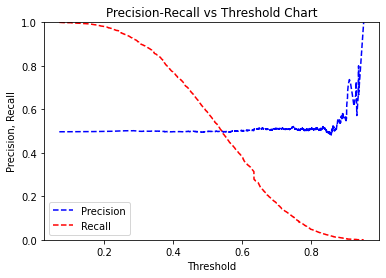

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
#getting the probability of being in each class from classifier without applying the threshold
Y_probs=classifier.predict_proba(X_test) 
print(Y_probs)
print(Y_predict)
precision, recall, thresholds = precision_recall_curve(Y_test , Y_probs[:, 1]) 

#retrieve probability of being 1(in second column of Y_prob)
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

As can be seen, increasing precision will result in a decrease in the recall and vice versa. The trade-off point between precision and recall is where the two curves coincide, around the threshold = 0.5, and will result in precision and recalls equal to 0.5. 

In [32]:
EM1 = 'accuracy'
mean_test_scores = classifier.cv_results_.get('mean_test_score')
CVS1 = mean_test_scores[classifier.best_index_]
CPS1 = classifier.score(X_test, Y_test)
T1 = runtime_train
PT1 = runtime_pred
print( "Training Time was: " + str(T1))
print("Prediction Time was: " + str(PT1))

AttributeError: ignored

In [33]:
# Here we tried to make an estimation of Bias and Variance
%pip install mlxtend --upgrade
from mlxtend.evaluate import bias_variance_decomp
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        classifier, X_train, Y_train, X_test, Y_test)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

     |████████████████████████████████| 1.3 MB 5.1 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


KeyboardInterrupt: ignored

# SVM 

Initialize and train svm model

In [30]:
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time

svc = svm.SVC()
tst_size = 0.2
ns, nf = np.shape(X) 
# split data to train and test 
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
# cross validation
# scores = cross_val_score(svc, X_train, Y_train, cv=5 ,scoring= 'f1')
cv = 5
scoring = 'f1'
param_grid = {'C': [0.1, 1, 10, 100],  
                'gamma': [1, 0.1, 0.01, 0.001], 
                'kernel': ['rbf', 'linear', 'sigmoid']}
# evaluate hyper-parameters 
clf = GridSearchCV(svc, param_grid, scoring = scoring, cv = cv ,verbose = 1, n_jobs=-1, return_train_score=1)
# train model
start_train = time.time()
trained_model = clf.fit(X_train, Y_train)
runtime_train = start_train - time.time()
# predict data
start_pred = time.time()
Y_pred = trained_model.predict(X_test)
runtime_pred = start_pred - time.time()
# scores = cross_val_score(clf.best_estimator_, X_train, Y_train, cv=5 ,scoring= 'accuracy')
# print(scores)
print(clf.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.04798574853727491


In [ ]:
import pickle

# save the model to disk
filename = 'svm_model.sav'
pickle.dump(trained_model, open(filename, 'wb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

### Classification Report
Print some information about the trained model such as training time, ... 

In [ ]:
print("Best parameters set found on development set:")
print(trained_model.best_params_)
print()
# print(sorted(trained_model.cv_results_.keys()))
print(trained_model.best_score_)
# print(trained_model.cv_results_.mean_fit)

print('-----------------')
# print(Y_pred)
print('\nclassification report: \n')
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

EM2 = scoring
mean_test_scores = trained_model.cv_results_.get('mean_test_score')
CVS2 = mean_test_scores[trained_model.best_index_]
CPS2 = trained_model.score(X_test, Y_test)
T2 = runtime_train
PT2 = runtime_pred
print( "Training Time was: " + str(T2))
print("Prediction Time was: " + str(PT2))

Best parameters set found on development set:
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

0.04798574853727491
-----------------

classification report: 

              precision    recall  f1-score   support

           0       0.49      0.96      0.65       990
           1       0.49      0.04      0.07      1010

    accuracy                           0.49      2000
   macro avg       0.49      0.50      0.36      2000
weighted avg       0.49      0.49      0.36      2000



### Confusion Matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

### Learning Curve


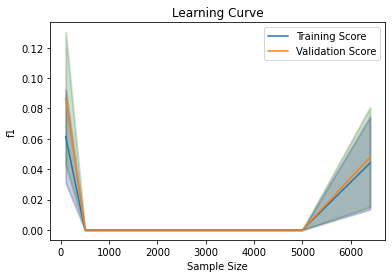

Training scores:

       cv1       cv2       cv3       cv4       cv5
100   0.0  0.076923  0.076923  0.076923  0.076923
500   0.0  0.000000  0.000000  0.000000  0.000000
1000  0.0  0.000000  0.000000  0.000000  0.000000
5000  0.0  0.000000  0.000000  0.000000  0.000000
6400  0.0  0.075374  0.064346  0.014810  0.065698

 ----------------------------------------------------------------------

Validation scores:

       cv1       cv2       cv3       cv4       cv5
100   0.0  0.120536  0.106667  0.102793  0.102450
500   0.0  0.000000  0.000000  0.000000  0.000000
1000  0.0  0.000000  0.000000  0.000000  0.000000
5000  0.0  0.000000  0.000000  0.000000  0.000000
6400  0.0  0.087760  0.063084  0.019560  0.069525


In [ ]:
ns = [100,500,1000,5000,6400]
train_sizes, train_scores, valid_scores = learning_curve(trained_model, X_train, Y_train, train_sizes=ns, cv=cv, scoring= scoring, n_jobs = -1)

train_scores_mean =  train_scores.mean(axis = 1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean =  valid_scores.mean(axis = 1)
validation_scores_std  = valid_scores.std(axis = 1)

xlabel = 'Sample Size'
ylabel = scoring
plt_title = 'Learning Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(train_sizes, train_scores_mean, label = 'Training Score')
ax.plot(train_sizes, validation_scores_mean, label = 'Validation Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkblue", lw=2)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="darkgreen", lw=2)

plt.legend()
# plt.yscale('log')
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )

### Validation Curve


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min finished


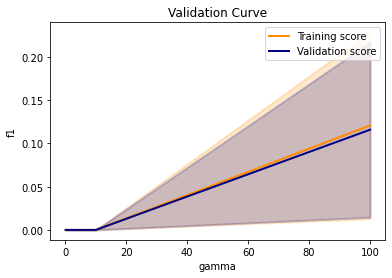

ValueError: ignored

In [16]:
c_list = param_grid.get('C')
train_scores, valid_scores = validation_curve(SVC(), X_train, Y_train, 
                                              param_name="gamma",
                                              param_range=c_list , 
                                              cv=cv, 
                                              scoring = scoring,
                                              verbose=1, 
                                              n_jobs=-1
                                             )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

xlabel = 'gamma'
ylabel = scoring
plt_title = 'Validation Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
plt.plot(c_list, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(c_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.plot(c_list, valid_scores_mean, label="Validation score",
             color="navy", lw=2)
plt.fill_between(c_list, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# scale model

lrg = LogisticRegression(fit_intercept=True)
tst_size = 0.2
ns, nf = np.shape(X)
clf = Pipeline([('scaler', StandardScaler() ), 
                        ('p_transformer', PolynomialFeatures(degree = 5)), 
                        ('clf', LogisticRegression(solver='liblinear'))])
start = time.time()
trained_model = clf.fit(X_train,Y_train)
runtime_train = time.time() - start()
### Testing the model
start = time.time()
Y_pred = trained_model.predict(X_test)
runtime_pred = time.time() - start()
out_error = np.abs(Y_test - Y_pred).sum() / len(Y_test)

in_error = np.abs(Y_train - trained_model.predict(X_train)  ).sum() / len(Y_train)

print(f'The in-sample error is {in_error:.4f}, and the out_sample error is {out_error:.4f}.')

### Classification Report
Print some information about the trained model such as training time, ... 

In [ ]:
print("Best parameters set found on development set:")
print(trained_model.best_params_)
print()
# print(sorted(trained_model.cv_results_.keys()))
print(trained_model.best_score_)
# print(trained_model.cv_results_.mean_fit)

print('-----------------')
# print(Y_pred)
print('\nclassification report: \n')
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

EM3 = scoring
mean_test_scores = trained_model.cv_results_.get('mean_test_score')
CVS3 = mean_test_scores[trained_model.best_index_]
CPS3 = trained_model.score(X_test, Y_test)
T3 = runtime_train
PT3 = runtime_pred
print( "Training Time was: " + str(T3))
print("Prediction Time was: " + str(PT3))

Best parameters set found on development set:
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

0.04798574853727491
-----------------

classification report: 

              precision    recall  f1-score   support

           0       0.49      0.96      0.65       990
           1       0.49      0.04      0.07      1010

    accuracy                           0.49      2000
   macro avg       0.49      0.50      0.36      2000
weighted avg       0.49      0.49      0.36      2000



### Confusion Matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

### Learning Curve

In [ ]:
scoring= 'f1'

ns = [10,100,200,250,300,500,1000,5000,6000,8000]
train_sizes, train_scores, valid_scores = learning_curve(trained_model, X, Y, train_sizes=ns,
                                                         cv=cv, scoring= scoring, n_jobs = -1)

train_scores_mean =  train_scores.mean(axis = 1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean =  valid_scores.mean(axis = 1)
validation_scores_std  = valid_scores.std(axis = 1)

xlabel = 'Sample Size'
ylabel = scoring
plt_title = 'Learning Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(train_sizes, train_scores_mean, label = 'Training Score')
ax.plot(train_sizes, validation_scores_mean, label = 'Validation Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkblue", lw=2)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="darkgreen", lw=2)

plt.legend()
# plt.yscale('log')
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )

### Validation Curve

In [ ]:
c_list = [1,2,3,4,5,7,15,25]
train_scores, valid_scores = validation_curve(clf, X_train, Y_train, 
                                              param_name='p_transformer__degree',
                                              param_range= c_list, 
                                              cv=cv, 
                                              scoring = scoring,
                                              verbose=1, 
                                              n_jobs=-1
                                             )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

xlabel = 'Polynomial Degree'
ylabel = scoring
plt_title = 'Validation Curve'

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
plt.plot(c_list, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(c_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.plot(c_list, valid_scores_mean, label="Validation score",
             color="navy", lw=2)
plt.fill_between(c_list, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

print('Training scores:\n\n', pd.DataFrame(train_scores, columns=[f'cv{i+1}' for i in range(cv)]) )
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)]) )

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3, weights='uniform', 
                                  algorithm='auto', leaf_size = 30, p = 2, metric='minkowski', metric_params = None)
#check
%t classifier.fit(X_train , Y_train)

#Testing the classification on the test sample
Y_predict_knn = classifier.predict(X_test)
#check
%t Y_predict_knn = classifier.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121 , xlabel = '$\delta(rc=0.8)$', ylabel='$\delta(rc=1.2)$' , title = 'Result of the Classification')

ax.scatter(*X_test[:,:2].T, c=Y_test)    

ax = fig.add_subplot(122 , xlabel = '$\delta(rc=0.8)$', ylabel='$\delta(rc=1.2)$' , title = 'Predicitions of the Knn classifier')
plt.scatter(*X_test[:,:2].T, c = Y_predict_knn)
plt.show()


plt.show()

In [ ]:
from sklearn.metrics import classification_report
clf_report = classification_report(Y_test, Y_predict_knn)
print(clf_report)

### Validation Curve

In [ ]:
from sklearn.model_selection import validation_curve


param_range = np.arange(1,30, 1)
print(param_range)

train_scores, test_scores = validation_curve(
classifier, X=X, y=Y,cv=5, param_name="n_neighbors", param_range=param_range,
scoring="accuracy", n_jobs=1)


train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_scores_mean,'r--',label = 'Training Score')
plt.plot(param_range, test_scores_mean,'g--',label = 'Cross-validation score')

plt.title('validation curve')
plt.xlabel('# Neighbors')
plt.ylabel('Score')
plt.legend(loc='upper left')

plt.show()

Optimal value of $n_{neighbor}$ = 28

Run-Time vs. leaf-size


In [ ]:
import time

leaf_range = np.arange(1,40,1)

t_time = np.array([])
p_time = np.array([])

for i in leaf_range:
    print(i)
    classifier = KNeighborsClassifier(n_neighbors=20 , leaf_size=i, p=2, metric='minkowski')
    
    start = time.time()
    classifier.fit(X_train, Y_train)
    stop = time.time()
    t1 = stop - start
    t_time = np.append(t_time , t1)
    
    start = time.time()
    n = classifier.predict(X_test)
    stop = time.time()
    t2 = stop - start
    p_time = np.append(p_time , t2)
    
plt.plot(leaf_range , t_time , 'b--' , label = 'Training time')
plt.plot(leaf_range , p_time , 'r--' , label = 'Prediction time')
plt.title('Leaf_size versus time')
plt.xlabel('Leaf size')
plt.ylabel('Time')
plt.legend(loc='upper left')
plt.show()

### Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve, validation_curve
import pandas as pd
train_sizes = np.arange(1000,48000,1000)

print('learning started')
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator= classifier , X = X,
                                                   y = Y, train_sizes = train_sizes, cv = 5, random_state = 0)

print('Training scores:\n\n', pd.DataFrame( train_scores) )

print('\nValidation scores:\n\n', pd.DataFrame(validation_scores) )

Fine Tuning The Model

In [ ]:
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, train_size = 25000 , random_state= 0)

print(len(X_train))
print(len(X_test))
print(len(Y))

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=20 , leaf_size=30 , p=2, metric='minkowski')
%t classifier.fit(X_train , Y_train)

#Testing the classification on the test sample
Y_predict_knn = classifier.predict(X_test)
%t Y_predict_knn = classifier.predict(X_test)
print(len(Y_test))
print(len(Y_predict_knn[Y_predict_knn == 1]))

In [ ]:
from sklearn.metrics import classification_report
clf_report = classification_report(Y_test, Y_predict_knn)
print(clf_report)

Metrics


In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test , Y_predict_knn)
print('Here is the confusion matrix for the Knn classifier: \n'  )
print('TP = {}'.format(conf_matrix[0][0]),'  FP = {}'.format(conf_matrix[0][1]) , '\n')
print('FN = {}'.format(conf_matrix[1][0]),'  TN = {}'.format(conf_matrix[1][1]) , '\n')

In [ ]:
import itertools

class_names = {'IN' , 'OUT'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    #, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],3),
                 horizontalalignment='center',
                 verticalalignment='center',
                 #transform=ax.transAxes,
                 fontsize = 13,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.axis('equal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Accuracy

In [ ]:
acurracy = (conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
print('The accuracy of the model is {}%' .format(round(acurracy*100, 3)))

Recall

In [ ]:
from sklearn.metrics import recall_score, precision_score
recall = recall_score(Y_test, Y_predict_knn, pos_label=0)
precision = precision_score(Y_test, Y_predict_knn, pos_label = 0)
print(f"The recall for the Knn classifier: \n {round(recall,3)}"  )
print(f"The precision for Knn classifier: \n {round(precision,3)}"  )

Precision - Recall curve

In [ ]:
Y_probs=classifier.predict_proba(X_test) 
print(Y_probs)
print(Y_predict_knn)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, thresholds = precision_recall_curve(Y_test , Y_probs[:, 1]) 

#retrieve probability of being 1(in second column of Y_prob)
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

In [ ]:
print("Best parameters set found on development set:")
print(trained_model.best_params_)
print()
# print(sorted(trained_model.cv_results_.keys()))
print(trained_model.best_score_)
# print(trained_model.cv_results_.mean_fit)

print('-----------------')
# print(Y_pred)
print('\nclassification report: \n')
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

EM4 = scoring
mean_test_scores = trained_model.cv_results_.get('mean_test_score')
CVS4 = mean_test_scores[trained_model.best_index_]
CPS4 = trained_model.score(X_test, Y_test)
T4 = runtime_train
PT4 = runtime_pred
print( "Training Time was: " + str(T4))
print("Prediction Time was: " + str(PT4))

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics

clf = DecisionTreeClassifier(max_depth=20)

%t clf.fit(x_train,y_train)

y_pred_dt = clf.predict(x_test)
%t y_pred_dt = clf.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_dt))

In [ ]:
clf = DecisionTreeClassifier(max_depth=20)
clf = clf.fit(x_train,y_train)
plt.scatter(x['den_contrast for 12.4'],x['den_contrast for 13.0'],c=clf.predict(x),s=15)
plt.xlabel('$ \delta_{12.4} $')
plt.ylabel('$\delta_{13.0} $')
plt.title('Predicitions of the Decision Tree classifier')
plt.show()

### Validation Curve

In [ ]:
from sklearn.model_selection import validation_curve


param_range = np.arange(1, 40, 1)

train_scores, test_scores = validation_curve(
    clf, X=x, y=y,cv=5, param_name="max_depth", param_range=param_range,
    scoring="accuracy", n_jobs=1)


train_scores_mean = np.mean(train_scores, axis=1)
#train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
#test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean,'r--',label = 'Training Score')
plt.plot(param_range, test_scores_mean,'g--',label = 'Cross-validation score')

plt.title('validation curve')
plt.xlabel('Tree max_depth')
plt.ylabel('Score')
plt.legend(loc='upper left')

plt.show()


### Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve

clf = DecisionTreeClassifier(max_depth=6)
clf.fit(x_train,y_train)

train_sizes = np.arange(1000,48000,1000)

#computing training score and validation score for each sample size cv times
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator= clf , X = x,
                                                   y = y, train_sizes = train_sizes, cv = 5, random_state = 0)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

plt.title('Learning curve')
plt.plot(ns_list[1:], train_scores_mean[1:],'r--',label = 'Training Score')
plt.plot(ns_list[1:], validation_scores_mean[1:], 'g--', label = 'Validation Score')
plt.xlabel('# Training samples')
plt.ylabel('Score')
plt.legend(loc='upper right')

plt.show()

### Fine Tuning The Model

In [ ]:
from sklearn.model_selection import train_test_split 


x = df.iloc[:,2:]
y = df['in-halo']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=20000, random_state=1)

clf = DecisionTreeClassifier(max_depth=6)

%t clf.fit(x_train,y_train)

y_pred_dt = clf.predict(x_test)
%t y_pred_dt = clf.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_dt))

### Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report
clf_report = classification_report(y_test, clf.predict(x_test))
print(clf_report)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y, clf.predict(x)))

In [ ]:
import itertools

conf=confusion_matrix(y, clf.predict(x))
class_names = {'IN' , 'OUT'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    #, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],3),
                 horizontalalignment='center',
                 verticalalignment='center',
                 #transform=ax.transAxes,
                 fontsize = 13,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.axis('equal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
from sklearn.metrics import recall_score, precision_score
print(recall_score(y, clf.predict(x), pos_label=0))
print(precision_score(y, clf.predict(x), pos_label = 0))

### Precision-Recall curve

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_probs=clf.predict_proba(x_test) 
precision, recall, thresholds = precision_recall_curve(y_test , y_probs[:, 1]) 
thresholds=np.append(0,thresholds)

area = auc(recall, precision)
#print(area)

plt.figure(figsize=(15, 15))
ax1 = plt.subplot(221,xlabel='Threshold',ylabel='Precision, Recall' ,title='Precision-Recall vs Threshold')
ax1.plot(thresholds, precision, "b--", label="Precision")
ax1.plot(thresholds, recall, "r--", label="Recall")
plt.legend(loc="lower left",prop={'size': 15})

ax2 = plt.subplot(222,title='Precision-Recall curve',xlabel='Recall',ylabel='Precision')
ax2.plot( recall,precision,'g--',label='AUC={:.2f}'.format(area))
ax2.set( ylim=(-.05, 1.05))
plt.legend(loc="lower left",prop={'size': 15})

plt.show()

In [ ]:
print("Best parameters set found on development set:")
print(trained_model.best_params_)
print()
# print(sorted(trained_model.cv_results_.keys()))
print(trained_model.best_score_)
# print(trained_model.cv_results_.mean_fit)

print('-----------------')
# print(Y_pred)
print('\nclassification report: \n')
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

EM5 = scoring
mean_test_scores = trained_model.cv_results_.get('mean_test_score')
CVS5 = mean_test_scores[trained_model.best_index_]
CPS5 = trained_model.score(X_test, Y_test)
T5 = runtime_train
PT5 = runtime_pred
print( "Training Time was: " + str(T5))
print("Prediction Time was: " + str(PT5))

# Comparing Models

A table is created to compare the five recently-traind models above. It includes evaluation metric(s), training time and prediction time of each models. Also, we sorted models based on their performance from different aspects. 

In [ ]:
table = pd.DataFrame({'Name':['Random Forest', 'SVM', 'Logestic Regression', 'KNN', 'Decision Tree'],
                        'Evaluation Metric(s)': [EM1, EM2, EM3, EM4, EM5],
                        'Corresponding Validation Score': [CVS1, CVS2, CVS3, CVS4, CVS5],
                        'Corresponding Prediction Score':  [CPS1, CPS2, CPS3, CPS4, CPS5],
                        'Training Time': [T1, T2, T3, T4, T5],
                        'Prediction Time': [PT1, PT2, PT3, PT4, PT5],
})

print('Sort models based on their validation scores: \n' + str(table.sort_values(by=['Corresponding Validation Score', ascending= False]).loc[:, ['Name', 'Corresponding Validation Score']))
print('\nSort models based on their prediction scores: \n' + str(table.sort_values(by=['Corresponding Prediction Score', ascending= False]).loc[:, ['Name', 'Corresponding Prediction Score']))
print('\nSort models based on their validation scores: \n' + str(table.sort_values(by=['Training Time', ascending= True]).loc[:, ['Name', 'Training Time']))
print('\nSort models based on their validation scores: \n' + str(table.sort_values(by=['Prediction Time', ascending= True]).loc[:, ['Name', 'Prediction Time']))
